
# Import dependencies 

In [40]:
# COCO related libraries 
from samples.coco import coco
from pycocotools.coco import COCO

# MaskRCNN libraries 
from mrcnn import utils, visualize
from mrcnn import model as modellib

# Misc
import os 
import cv2
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
import skimage.io
import random 
import json 
%matplotlib inline 


# Constants 

In [41]:
# Number of classes in dataset. 
NUM_CLASSES = 2

# Relative path to .h5 weights file 
WEIGHTS_FILE = "C:/Users/FATTY/MaskRCNN/myMaskRCNN/logs/maskrcnn_config20200630T1337/mask_rcnn_maskrcnn_config_0094.h5"

# Relative path to annotations JSON file 
ANNOTATIONS_FILE = "C:/Users/FATTY/MaskRCNN/myMaskRCNN/Test/annotations.json"

ANNOTATION_IMAGE_DIR = "C:/Users/FATTY/MaskRCNN/myMaskRCNN/Test/images"

TEST_IMAGE_DIR = "C:/Users/FATTY/MaskRCNN/myMaskRCNN/Test/test_image"

MODEL_NAME = "model_1"


# Additional setup

In [42]:
# Set the root directory to the root directiory of MASK RCNN git repo
ROOT_DIR = os.getcwd()

# Directory to save trained models and logs 
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# select which GPU to use 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"] = "0";


# Declare inference configuration

In [43]:
class InferenceConfig(coco.CocoConfig):
    """Configuration for evaluation"""
    
    # Give the configuration a recognizable name 
    NAME = MODEL_NAME
    
    # How many GPUs 
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # NUmber of classes including background 
    NUM_CLASSES = 1 + 1 # background + building
    
    # Min and Max image dimensions
    IMAGE_MIN_DIM = 1152
    IMAGE_MIN_DIM = 1280


    # Matterport use resnet101, here we downsize to fit our graphic card 
    BACKBONE = "resnet101" 


    # RPN ANCHOR SCALES 
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)

    # changed to 512 because that's the number use in the original MaskRCNN paper 
    
    TRAIN_ROIS_PER_IMAGE = 200
    MAX_GT_INSTANCES = 114
    POST_NMS_ROIS_INFERENCE = 1000
    POST_NMS_ROIS_TRAINING = 2000

    DETECTION_MAX_INSTANCES = 125
    DETECTION_MIN_CONFIDENCE = 0.8
    
    MINI_MASK_SHAPE = (128, 128)


# Display configuration 

In [44]:
InferenceConfig().display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        125
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1280
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        


# Create class to load dataset

In [45]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """

    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        
        
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids


# Load dataset to get list of class names automatically instead of doing it manually

In [46]:
coco_dataset = CocoLikeDataset()
coco_dataset.load_data(ANNOTATIONS_FILE, ANNOTATION_IMAGE_DIR)
coco_dataset.prepare()
class_names = coco_dataset.class_names


# Build MaskRCNN Model

In [47]:
model = modellib.MaskRCNN(mode = "inference", model_dir = MODEL_DIR, config = InferenceConfig())


# Load weights into model

In [48]:
if WEIGHTS_FILE is None:
    model.load_weights(model.find_last(), by_name = True)
else:
    model.load_weights(WEIGHTS_FILE, by_name = True)

Re-starting from epoch 94



# Run detection model

Processing 1 images
image                    shape: (2360, 4800, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 4800.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


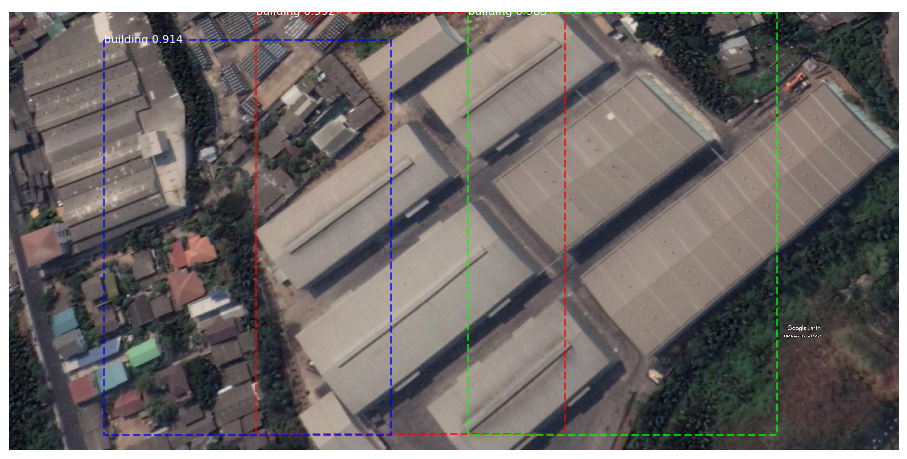

In [49]:
# Load a random image from the image folder
file_names = next(os.walk(TEST_IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(TEST_IMAGE_DIR, random.choice(file_names)))

# Run detection 
results = model.detect([image], verbose=1)

# visualize results 
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])